
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_27814/3381654816.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


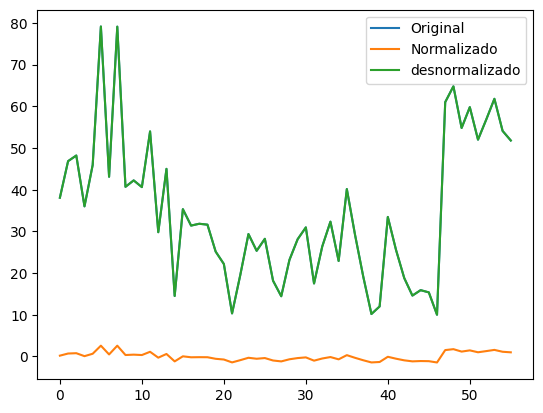

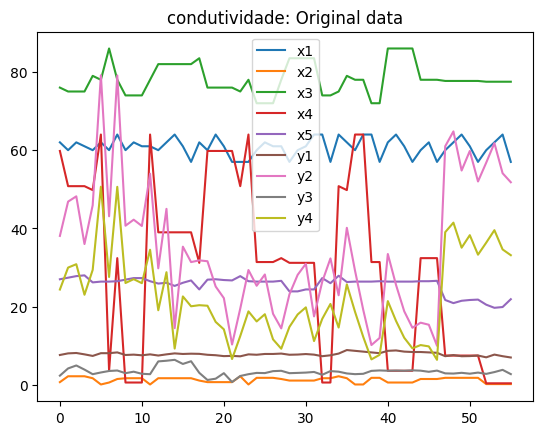

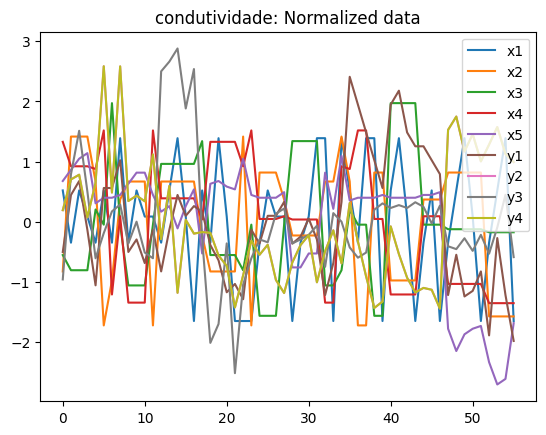

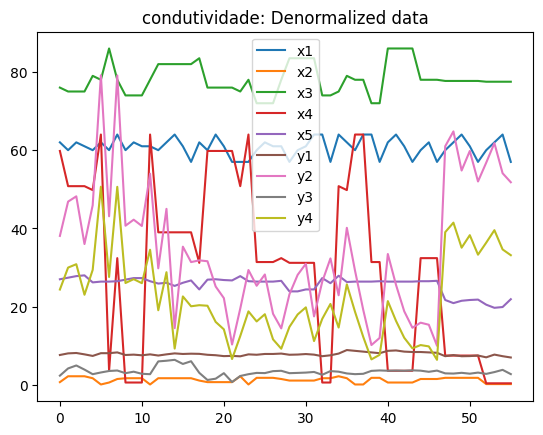

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y2"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y2")
test_out_scaler()
show_norm(label="condutividade")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-04-05 13:09:42.837935: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 13:09:42.869829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 13:09:42.869865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 13:09:42.871139: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 13:09:42.877150: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 13:09:42.878020: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [12]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [13]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[15,2], [15,5], [15,7], [20,2], [20,5], [20, 7], [20, 10], [30, 5], [30, 10], [30, 15]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[15, 2], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  0.48124983399975463
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.3698291780001455
Stopped at epoch:  11
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.207161599999381
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.20595111699913105
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.16414270799941733
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++


Elapsed time:  0.20223380400057067
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Elapsed time:  0.16215547999854607
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Elapsed time:  0.16452614599984372
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 9 ++++++++++++++++++
Elapsed time:  0.1598781920001784
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 10 ++++++++++++++++++
Elapsed time:  0.18593807199977164
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 11 ++++++++++++++++++
Elapsed time:  0.16427828099949693
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 12 ++++++++++++++++++
Elapsed time:  0.16807775200140895
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_2_3,0.801362,0.906431,-0.051575,0.490344,58.485985,30.554437,296.674059,155.787239
model_3_2_0,0.802502,0.954928,0.143293,0.602410,58.150135,14.718111,241.697311,121.531872
model_3_2_2,0.803191,0.921055,0.008903,0.524883,57.947292,25.778995,279.611929,145.229792
model_3_2_1,0.803746,0.937301,0.073783,0.562250,57.783788,20.474107,261.307605,133.807538


DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Elapsed time:  0.20121266199930687
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Elapsed time:  0.19601074300044274
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Elapsed time:  0.22795232600037707
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Elapsed time:  0.2934808680001879
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Elapsed time:  0.16188353000143252
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Elapsed time:  0.16371904200059362
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Elapsed time:  0.2602254

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_3_0,0.831869,0.934264,0.926091,0.930613,49.503434,9.538990,12.642553,10.999492
model_3_3_23,0.842635,-0.075290,0.144823,0.044644,46.333630,156.035406,146.283081,151.446064
model_3_3_22,0.844775,-0.054477,0.154191,0.059487,45.703466,153.015330,144.680603,149.093089
model_3_3_21,0.847101,-0.031523,0.164550,0.075871,45.018851,149.684472,142.908603,146.495828
model_3_3_20,0.849619,-0.006234,0.176010,0.093946,44.277224,146.014674,140.948390,143.630538
model_3_3_19,0.852339,0.021599,0.188693,0.113874,43.476431,141.975914,138.778738,140.471371
model_3_3_18,0.855265,0.052190,0.202750,0.135837,42.614889,137.536796,136.374326,136.989751
model_3_3_17,0.858400,0.085765,0.218352,0.160031,41.691847,132.664709,133.705458,133.154473
model_3_3_1,0.858706,0.927764,0.898494,0.913449,41.601902,10.482153,17.363177,13.720279
model_3_3_16,0.861743,0.122556,0.235710,0.186674,40.707614,127.326068,130.736303,128.930891


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Elapsed time:  0.16986160200031009
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Elapsed time:  0.1666826939999737
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Elapsed time:  0.17792920399915602
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Elapsed time:  0.16162331300074584
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Elapsed time:  0.1600846340006683
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Elapsed time:  0.18317745300009847
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Elapsed time:  0.18530854

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_4_13,0.804121,-0.178215,-0.218109,0.196654,57.673535,229.109600,132.528915,183.659883
model_3_4_12,0.814201,-0.108745,-0.137698,0.245945,54.705514,215.600686,123.780337,172.391096
model_3_4_11,0.824981,-0.032018,-0.051726,0.299748,51.531593,200.680856,114.426677,160.090652
model_3_4_10,0.836378,0.052206,0.039399,0.358082,48.175863,184.302976,104.512325,146.754432
model_3_4_9,0.848199,0.143541,0.134768,0.420568,44.695526,166.542619,94.136244,132.469035
model_3_4_8,0.860023,0.240098,0.232616,0.485960,41.213924,147.766642,83.490582,117.519072
model_3_4_7,0.871002,0.336955,0.329655,0.551307,37.981459,128.932274,72.932775,102.579545
model_3_4_0,0.871440,0.819610,0.970689,0.912207,37.852572,35.077609,3.188987,20.071199
model_3_4_6,0.880016,0.427927,0.421970,0.612946,35.327421,111.242257,62.888990,88.487797
model_3_4_5,0.887428,0.519390,0.512381,0.674379,33.145053,93.456871,53.052424,74.443031


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.16499782800019602
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Elapsed time:  0.1733205030013778
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Elapsed time:  0.16066936400056875
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Elapsed time:  0.15876634499909414
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Elapsed time:  0.15967373500097892
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Elapsed time:  0.16128328000013425
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Elapsed time:  0.1626945

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_0,0.823666,0.851229,0.989937,0.902446,51.918745,47.611541,1.777764,26.042702
model_3_5_1,0.854631,0.869789,0.980748,0.911364,42.801514,41.671681,3.401319,23.662104
model_3_5_2,0.879101,0.883628,0.969532,0.916654,35.596769,37.242802,5.382808,22.249864
model_3_5_3,0.898414,0.893854,0.957043,0.919254,29.910266,33.970277,7.589174,21.555640
model_3_5_4,0.913625,0.901293,0.943834,0.919862,25.431631,31.589577,9.922842,21.393465
model_3_5_5,0.925570,0.906588,0.930317,0.919013,21.914644,29.894919,12.310927,21.620102
model_3_5_6,0.934916,0.910246,0.916802,0.917126,19.162987,28.724101,14.698573,22.123850
model_3_5_7,0.942195,0.912669,0.903524,0.914528,17.019724,27.948730,17.044447,22.817307
model_3_5_8,0.947834,0.914169,0.890653,0.911472,15.359355,27.468667,19.318390,23.633242
model_3_5_9,0.952175,0.914991,0.878313,0.908150,14.081449,27.205677,21.498350,24.519870


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.1666493430002447
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.16879128700020374
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.18961751099959656
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.16703526000128477
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.15903478000109317
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.16002994600057718
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.1594836

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_24,0.955233,0.912955,0.656107,0.826128,13.180905,13.935589,76.256480,43.263069
model_3_6_23,0.955828,0.914209,0.660969,0.828594,13.005776,13.734827,75.178522,42.649512
model_3_6_22,0.956478,0.915588,0.666326,0.831310,12.814324,13.514009,73.990648,41.973602
model_3_6_21,0.957187,0.917103,0.672221,0.834299,12.605526,13.271478,72.683258,41.229954
model_3_6_20,0.957959,0.918764,0.678706,0.837584,12.378320,13.005598,71.245432,40.412578
model_3_6_19,0.958796,0.920582,0.685824,0.841189,12.131857,12.714474,69.666907,39.515618
model_3_6_18,0.959701,0.922569,0.693630,0.845139,11.865339,12.396429,67.935956,38.532681
model_3_6_17,0.960676,0.924734,0.702175,0.849460,11.578273,12.049780,66.041108,37.457464
model_3_6_16,0.961721,0.927088,0.711510,0.854177,11.270551,11.672869,63.971233,36.283875
model_3_6_15,0.962836,0.929640,0.721686,0.859314,10.942447,11.264393,61.714661,35.005696


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.1645064549993549
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.24040597900057037
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.1610971830014023
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.1614007379994291
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.18739848299992445
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.20003525499851094
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.159811057

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_24,0.933816,0.921134,0.553077,0.821839,19.486786,37.801675,93.458850,63.993285
model_3_7_23,0.934728,0.921830,0.560743,0.824431,19.218289,37.468211,91.855884,63.062399
model_3_7_22,0.935727,0.922601,0.569177,0.827286,18.924274,37.098338,90.092148,62.036612
model_3_7_21,0.936818,0.923457,0.578445,0.830430,18.602899,36.687946,88.154145,60.907329
model_3_7_20,0.938008,0.924406,0.588614,0.833887,18.252448,36.233150,86.027498,59.665777
model_3_7_19,0.939303,0.925458,0.599757,0.837682,17.871207,35.729168,83.697440,58.302473
model_3_7_18,0.940708,0.926622,0.611943,0.841844,17.457665,35.170932,81.149072,56.807705
model_3_7_17,0.942226,0.927911,0.625245,0.846399,17.010607,34.553116,78.367509,55.171635
model_3_7_16,0.943861,0.929337,0.639730,0.851374,16.529255,33.869957,75.338348,53.384501
model_3_7_15,0.945613,0.930911,0.655462,0.856797,16.013411,33.115202,72.048607,51.436819


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.2219011880006292
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.17075222299899906
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.2789767819995177
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.3160253530004411
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.19981654599905596
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.16218534700055898
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.173403685

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_0,0.943760,0.893388,0.997526,0.937914,16.559065,31.093605,0.603400,16.745273
model_3_8_1,0.951061,0.896893,0.992023,0.937580,14.409200,30.071124,1.945529,16.835546
model_3_8_2,0.956367,0.899269,0.983051,0.935122,12.846976,29.378383,4.133667,17.498515
model_3_8_24,0.959645,0.894076,0.803577,0.855779,11.881919,30.892758,47.904635,38.898350
model_3_8_23,0.960003,0.894417,0.806641,0.857278,11.776418,30.793269,47.157401,38.494045
model_3_8_3,0.960159,0.900809,0.972012,0.931306,11.730678,28.929037,6.825924,18.527575
model_3_8_22,0.960390,0.894786,0.810025,0.858929,11.662482,30.685718,46.331925,38.048659
model_3_8_21,0.960807,0.895184,0.813762,0.860747,11.539911,30.569689,45.420658,37.558390
model_3_8_20,0.961252,0.895612,0.817884,0.862746,11.408666,30.444903,44.415429,37.019265
model_3_8_19,0.961726,0.896069,0.822425,0.864940,11.269033,30.311571,43.307939,36.427495


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.166009866999957
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.16074399299941433
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.1594311179997021
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.16253141999914078
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.1592676259988366
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.16117598100026953
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.2041319969

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_24,0.889984,0.691447,0.706079,0.698916,32.392381,145.323455,62.865143,106.519561
model_3_9_23,0.891454,0.695065,0.711711,0.703069,31.959575,143.619305,61.660488,105.050449
model_3_9_22,0.893079,0.699098,0.717914,0.707675,31.481078,141.720087,60.333802,103.420652
model_3_9_21,0.894873,0.703587,0.724734,0.712780,30.952973,139.605720,58.875044,101.614833
model_3_9_20,0.896853,0.708590,0.732226,0.718437,30.370154,137.249284,57.272731,99.613246
model_3_9_19,0.899035,0.714166,0.740442,0.724704,29.727700,134.623165,55.515304,97.395991
model_3_9_18,0.901437,0.720381,0.749435,0.731643,29.020354,131.696283,53.591909,94.941267
model_3_9_17,0.904079,0.727309,0.759262,0.739322,28.242373,128.432876,51.490164,92.224552
model_3_9_16,0.906979,0.735032,0.769966,0.747810,27.388436,124.795651,49.200663,89.221464
model_3_9_15,0.910159,0.743646,0.781602,0.757191,26.452219,120.738787,46.711966,85.902637


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[15, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.47482735100129503
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.2734776569996029
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.1593480659994384
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.15837086000101408
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.18194083600064914
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.1607127870011027
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_0,0.817258,0.944378,0.345016,0.635960,53.805406,10.554660,157.367853,79.643200
model_4_5_1,0.834261,0.926642,0.339052,0.624734,48.799243,13.920294,158.800801,82.099363
model_4_5_2,0.846987,0.906947,0.331018,0.611538,45.052371,17.657539,160.731006,84.986260
model_4_5_3,0.856447,0.886207,0.322258,0.597487,42.266804,21.593128,162.835832,88.060278
model_4_5_4,0.863381,0.865060,0.313303,0.583148,40.225299,25.605875,164.987441,91.197201
model_4_5_22,0.867503,0.617580,0.211253,0.416769,39.011751,72.566962,189.506191,127.597186
model_4_5_21,0.868255,0.624014,0.213885,0.421083,38.790243,71.346126,188.873806,126.653240
model_4_5_5,0.868352,0.843966,0.304412,0.568868,38.761679,29.608533,167.123509,94.321424
model_4_5_20,0.869051,0.631084,0.216776,0.425824,38.555742,70.004456,188.179168,125.616077
model_4_5_19,0.869888,0.638844,0.219948,0.431027,38.309455,68.531948,187.417020,124.477840


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.164421069999662
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.1608251690013276
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.16187942099895736
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.17457731699869328
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.15940042399961385
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.17175028100064083
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.160611810

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_0,0.884963,0.393485,0.999756,0.819337,33.870718,95.778585,0.091471,50.749378
model_4_6_1,0.898275,0.408980,0.999341,0.823689,29.951472,93.331711,0.246792,49.527040
model_4_6_2,0.908434,0.415552,0.998780,0.825293,26.960244,92.293824,0.456811,49.076401
model_4_6_3,0.916171,0.415973,0.998145,0.825020,24.682105,92.227321,0.694366,49.152996
model_4_6_4,0.922035,0.412184,0.997481,0.823476,22.955472,92.825730,0.943089,49.586844
model_4_6_5,0.926446,0.405572,0.996812,0.821089,21.656821,93.869826,1.193405,50.257382
model_4_6_6,0.929726,0.397134,0.996153,0.818164,20.690956,95.202400,1.439888,51.078871
model_4_6_7,0.932128,0.387588,0.995513,0.814922,19.983758,96.709903,1.679531,51.989730
model_4_6_24,0.933649,0.259188,0.988470,0.772291,19.535866,116.986265,4.316145,63.965029
model_4_6_8,0.933848,0.377453,0.994895,0.811518,19.477395,98.310354,1.910794,52.945849


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.23714098300115438
Stopped at epoch:  9
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.15948958199987828
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.20070265800131892
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.17927950599914766
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.16519167399928847
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.17285612500018033
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.161522

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_24,0.883840,0.867443,0.376752,0.751733,34.201437,85.155230,143.215679,112.477775
model_4_7_23,0.886766,0.870766,0.392942,0.758092,33.340004,83.020667,139.495255,109.596949
model_4_7_22,0.889877,0.874296,0.410234,0.764869,32.424000,80.752614,135.521899,106.526373
model_4_7_21,0.893170,0.878031,0.428628,0.772063,31.454443,78.353430,131.295111,103.267116
model_4_7_20,0.896639,0.881965,0.448117,0.779668,30.433017,75.826534,126.816634,99.821896
model_4_7_19,0.900275,0.886088,0.468674,0.787670,29.362514,73.177418,122.092899,96.196462
model_4_7_18,0.904065,0.890390,0.490262,0.796052,28.246701,70.413814,117.132240,92.398981
model_4_7_17,0.907993,0.894858,0.512831,0.804793,27.090044,67.543615,111.946171,88.438948
model_4_7_16,0.912040,0.899476,0.536314,0.813864,25.898355,64.577122,106.549994,84.329091
model_4_7_15,0.916185,0.904228,0.560640,0.823238,24.677934,61.524358,100.960076,80.082311


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.16598352599976351
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.16132288500011782
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.1631427239990444
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.16046973899938166
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.15933193700038828
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.1617679840001074
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.20477647

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_0,0.906050,0.992167,0.988879,0.992437,27.662064,3.476080,0.741777,2.189348
model_4_8_1,0.923603,0.993989,0.977370,0.992668,22.493830,2.667365,1.509393,2.122434
model_4_8_2,0.937428,0.994905,0.960991,0.991636,18.423350,2.261025,2.601868,2.421430
model_4_8_3,0.948265,0.995167,0.940704,0.989649,15.232495,2.144648,3.954956,2.996560
model_4_8_4,0.956709,0.994962,0.917368,0.986952,12.746479,2.235706,5.511410,3.777211
model_4_8_5,0.963235,0.994426,0.891743,0.983740,10.824824,2.473289,7.220549,4.707282
model_4_8_6,0.968229,0.993663,0.864497,0.980166,9.354580,2.812151,9.037822,5.741888
model_4_8_7,0.971999,0.992747,0.836212,0.976356,8.244398,3.218560,10.924416,6.844855
model_4_8_8,0.974796,0.991736,0.807384,0.972410,7.420858,3.667257,12.847167,7.987210
model_4_8_24,0.976771,0.978494,0.461267,0.924137,6.839359,9.543254,35.932683,21.961813


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.6555062569987058
Stopped at epoch:  14
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.27013324099971214
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.1592014569996536
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.16018480000093405
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.1621995280002011
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.1625297650007269
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.160906541

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_24,0.980856,0.945736,0.714558,0.902437,5.636651,13.994595,23.700863,18.562259
model_4_9_23,0.980942,0.946194,0.715118,0.902880,5.611434,13.876627,23.654315,18.477895
model_4_9_22,0.981036,0.946698,0.715733,0.903368,5.583725,13.746567,23.603274,18.385018
model_4_9_21,0.981139,0.947253,0.716407,0.903905,5.553312,13.603354,23.547297,18.282857
model_4_9_20,0.981252,0.947864,0.717147,0.904495,5.519964,13.445849,23.485860,18.170566
model_4_9_19,0.981376,0.948535,0.717954,0.905142,5.483521,13.272920,23.418871,18.047508
model_4_9_18,0.981511,0.949271,0.718832,0.905851,5.443722,13.083129,23.345939,17.912690
model_4_9_17,0.981659,0.950077,0.719787,0.906626,5.400354,12.875135,23.266639,17.765245
model_4_9_16,0.981819,0.950959,0.720823,0.907471,5.353238,12.647626,23.180696,17.604379
model_4_9_15,0.981992,0.951922,0.721937,0.908391,5.302207,12.399254,23.088163,17.429293


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[15, 7], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.48681294200105185
Stopped at epoch:  8
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.21518909399856057
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.16103316400040057
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.2279007429988269
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.19588876300076663
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.32305199899928994
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_2_13,0.800217,0.201434,-1.206109,-0.092468,58.823038,162.088394,215.561069,187.252008
model_5_2_12,0.803648,0.218183,-1.139885,-0.064202,57.812839,158.688796,209.090272,182.407123
model_5_2_0,0.803918,0.627223,-0.118272,0.466301,57.733252,75.664134,109.267495,91.477479
model_5_2_11,0.807148,0.237252,-1.069971,-0.033491,56.782128,154.818226,202.258950,177.143254
model_5_2_10,0.810632,0.258832,-0.996873,-0.000353,55.756394,150.438135,195.116470,171.463242
model_5_2_1,0.812878,0.578774,-0.223723,0.407638,55.095036,85.497994,119.571228,101.532458
model_5_2_9,0.813987,0.283087,-0.921169,0.035163,54.768603,145.514909,187.719366,165.375817
model_5_2_8,0.817074,0.310144,-0.843400,0.072988,53.859619,140.023000,180.120406,158.892367
model_5_2_2,0.818534,0.532531,-0.325441,0.351360,53.429865,94.884184,129.510202,111.178779
model_5_2_7,0.819730,0.340090,-0.763914,0.113085,53.077630,133.944886,172.353806,152.019674


DataFrame salvo em ../results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Elapsed time:  0.17164808699999412
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Elapsed time:  0.1727571369992802
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Elapsed time:  0.1612761579999642
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Elapsed time:  0.1619537129990931
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Elapsed time:  0.16644354699928954
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_3] | 6 ++++++++++++++++++
Elapsed time:  0.16394698600015545
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_3] | 7 ++++++++++++++++++
Elapsed time:  0.243418718

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_3_0,0.818231,0.982277,0.983530,0.985099,53.519147,4.381838,2.212571,3.361010
model_5_3_1,0.849189,0.964486,0.970396,0.971093,44.404062,8.780703,3.976942,6.520103
model_5_3_2,0.872709,0.942471,0.953806,0.953668,37.478832,14.223741,6.205619,10.450501
model_5_3_3,0.890493,0.918397,0.935177,0.934477,32.242475,20.175828,8.708230,14.779330
model_5_3_4,0.903849,0.893694,0.915520,0.914632,28.310105,26.283530,11.348879,19.255453
model_5_3_5,0.913783,0.869300,0.895549,0.894878,25.385133,32.314831,14.031781,23.711042
model_5_3_6,0.921076,0.845813,0.875764,0.875703,23.237844,38.121952,16.689647,28.036149
model_5_3_7,0.926334,0.823594,0.856510,0.857413,21.689844,43.615398,19.276185,32.161647
model_5_3_24,0.928353,0.637678,0.668271,0.696765,21.095301,89.582097,44.563967,68.397121
model_5_3_23,0.929003,0.642004,0.673336,0.700695,20.904038,88.512566,43.883540,67.510675


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Elapsed time:  0.3255328120012564
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Elapsed time:  0.19194682300076238
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Elapsed time:  0.1592326089994458
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Elapsed time:  0.15914787899964722
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Elapsed time:  0.16034023300016997
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Elapsed time:  0.16934846000003745
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Elapsed time:  0.20722759

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_24,0.927737,0.914771,0.371106,0.701832,21.276665,22.819089,122.668143,69.806885
model_5_4_23,0.928828,0.915703,0.381909,0.706632,20.955525,22.569476,120.560843,68.683063
model_5_4_22,0.930015,0.916721,0.393772,0.711899,20.605884,22.296979,118.246873,67.449871
model_5_4_21,0.931305,0.917829,0.406783,0.717671,20.226223,22.000425,115.709144,66.098664
model_5_4_20,0.932701,0.919031,0.421027,0.723983,19.815267,21.678542,112.930727,64.620749
model_5_4_19,0.934206,0.920332,0.436593,0.730874,19.372089,21.330156,109.894528,63.007524
model_5_4_18,0.935822,0.921736,0.453569,0.738379,18.896178,20.954432,106.583435,61.250436
model_5_4_17,0.937549,0.923242,0.472036,0.746532,18.387764,20.551089,102.981311,59.341777
model_5_4_0,0.939184,0.935057,0.944569,0.938949,17.906274,17.387743,10.811958,14.293254
model_5_4_16,0.939382,0.924852,0.492071,0.755361,17.847928,20.120082,99.073467,57.274625


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.28449823099981586
Stopped at epoch:  11
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.17523995800002012
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.25317596300010337
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.2044406479999452
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.17395326499899966
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.3817201040001237
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.2822928

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_24,0.970541,0.774470,0.903422,0.850092,8.673711,39.689567,15.875009,28.482712
model_5_5_23,0.970800,0.776137,0.904937,0.851526,8.597372,39.396184,15.626063,28.210244
model_5_5_22,0.971083,0.777974,0.906598,0.853103,8.514268,39.072815,15.353046,27.910561
model_5_5_21,0.971389,0.780000,0.908417,0.854837,8.424005,38.716445,15.054066,27.581214
model_5_5_20,0.971721,0.782228,0.910405,0.856739,8.326294,38.324335,14.727243,27.219817
model_5_5_0,0.972067,0.881815,0.973912,0.931427,8.224579,20.798633,4.288182,13.029013
model_5_5_19,0.972079,0.784678,0.912574,0.858823,8.220879,37.893176,14.370681,26.823756
model_5_5_18,0.972464,0.787367,0.914935,0.861103,8.107687,37.419975,13.982626,26.390641
model_5_5_17,0.972874,0.790313,0.917497,0.863591,7.986748,36.901397,13.561383,25.917866
model_5_5_16,0.973310,0.793536,0.920270,0.866300,7.858371,36.334241,13.105586,25.403118


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.1706747810003435
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.1635737610013166
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.21528403599950252
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.2462204509993171
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.16372765000051004
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.16505485999914526
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.163927438

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_0,0.975224,0.999780,0.945389,0.988392,7.295033,0.105603,8.954500,4.269790
model_5_6_1,0.978956,0.999527,0.944553,0.988042,6.196207,0.226852,9.091697,4.398545
model_5_6_2,0.981925,0.999182,0.943674,0.987620,5.321906,0.392113,9.235674,4.553789
model_5_6_3,0.984282,0.998773,0.942782,0.987151,4.627833,0.587937,9.381998,4.726319
model_5_6_4,0.986148,0.998323,0.941895,0.986655,4.078430,0.803760,9.527480,4.909040
model_5_6_5,0.987620,0.997848,0.941027,0.986145,3.645064,1.031271,9.669756,5.096445
model_5_6_6,0.988776,0.997363,0.940189,0.985635,3.304698,1.263952,9.807145,5.284274
model_5_6_7,0.989679,0.996877,0.939388,0.985131,3.038719,1.496761,9.938480,5.469330
model_5_6_8,0.990381,0.996399,0.938629,0.984642,2.832166,1.725835,10.063006,5.649215
model_5_6_9,0.990922,0.995935,0.937913,0.984172,2.672955,1.948310,10.180312,5.822195


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.1752462699987518
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.16261478799970064
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.16254871400087723
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.17858294500001648
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.17708142700030294
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.1815972549993603
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.17647053

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_24,0.991142,0.930074,0.941991,0.934138,2.608145,12.213927,4.488334,8.578350
model_5_7_23,0.991192,0.930281,0.942897,0.934537,2.593285,12.177896,4.418268,8.526306
model_5_7_22,0.991248,0.930509,0.943896,0.934978,2.576998,12.138035,4.340980,8.468837
model_5_7_21,0.991308,0.930761,0.944996,0.935465,2.559179,12.093981,4.255819,8.405431
model_5_7_20,0.991374,0.931040,0.946208,0.936002,2.539726,12.045267,4.162075,8.335534
model_5_7_19,0.991446,0.931348,0.947540,0.936593,2.518543,11.991526,4.058994,8.258576
model_5_7_18,0.991524,0.931687,0.949003,0.937243,2.495527,11.932232,3.945793,8.173901
model_5_7_17,0.991609,0.932061,0.950607,0.937957,2.470620,11.866908,3.821697,8.080924
model_5_7_16,0.991700,0.932473,0.952362,0.938739,2.443765,11.795022,3.685909,7.978966
model_5_7_15,0.991798,0.932925,0.954278,0.939596,2.414941,11.715975,3.537660,7.867361


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.36924886599990714
Stopped at epoch:  15
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.16173773300033645
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.1626968080017832
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.16180491500017524
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.2284801450005034
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.1779946620008559
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.16328906

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_24,0.995092,0.963530,0.987047,0.973768,1.444984,7.400877,1.777645,4.754656
model_5_8_23,0.995117,0.963750,0.987067,0.973906,1.437800,7.356343,1.774816,4.729742
model_5_8_22,0.995144,0.963993,0.987090,0.974058,1.429906,7.307076,1.771723,4.702206
model_5_8_21,0.995173,0.964261,0.987115,0.974226,1.421229,7.252561,1.768330,4.671735
model_5_8_20,0.995205,0.964559,0.987142,0.974412,1.411714,7.192212,1.764623,4.638052
model_5_8_19,0.995241,0.964887,0.987171,0.974617,1.401302,7.125551,1.760597,4.600870
model_5_8_18,0.995279,0.965250,0.987203,0.974843,1.389922,7.051927,1.756214,4.559824
model_5_8_17,0.995321,0.965651,0.987237,0.975093,1.377516,6.970594,1.751482,4.514552
model_5_8_16,0.995367,0.966093,0.987275,0.975368,1.364016,6.880907,1.746374,4.464655
model_5_8_15,0.995417,0.966580,0.987314,0.975671,1.349383,6.782039,1.740921,4.409750


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.27751625099881494
Stopped at epoch:  11
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.1602286430006643
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.1613293110003724
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.16329709199999343
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.23819860100047663
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.1619586029992206
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.17196705

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_0,0.997527,0.994830,0.992131,0.993463,0.728117,1.141113,2.234813,1.655797
model_5_9_1,0.997710,0.994980,0.992271,0.993606,0.674268,1.108127,2.195197,1.619688
model_5_9_2,0.997858,0.995099,0.992388,0.993722,0.630584,1.081818,2.162078,1.590174
model_5_9_3,0.997979,0.995194,0.992485,0.993818,0.595137,1.060877,2.134326,1.566026
model_5_9_4,0.998076,0.995269,0.992567,0.993896,0.566371,1.044268,2.111020,1.546266
model_5_9_5,0.998156,0.995329,0.992636,0.993959,0.543019,1.031132,2.091402,1.530082
model_5_9_6,0.998220,0.995375,0.992695,0.994012,0.524060,1.020773,2.074843,1.516804
model_5_9_7,0.998272,0.995412,0.992744,0.994055,0.508663,1.012642,2.060833,1.505907
model_5_9_8,0.998315,0.995441,0.992786,0.994090,0.496154,1.006291,2.048968,1.496961
model_5_9_9,0.998349,0.995463,0.992821,0.994119,0.485988,1.001375,2.038849,1.489595


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[15, 7], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.4600117780009896
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.4282627049997245
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.3411543900001561
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.1586729970003944
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.2211954300000798
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.15891933499915467
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_0,0.831072,0.921678,0.975184,0.959398,49.738283,13.794426,8.924638,11.502764
model_6_5_1,0.857616,0.908481,0.966769,0.950028,41.922753,16.118726,11.950928,14.157419
model_6_5_2,0.878316,0.894784,0.956718,0.939515,35.828020,18.531118,15.565672,17.135610
model_6_5_3,0.894391,0.881176,0.945528,0.928352,31.094793,20.927733,19.590090,20.298247
model_6_5_4,0.906787,0.868036,0.933526,0.916857,27.445237,23.241973,23.906650,23.554764
model_6_5_5,0.916236,0.855572,0.920938,0.905235,24.662945,25.437197,28.433594,26.847277
model_6_5_6,0.923320,0.843872,0.907950,0.893625,22.577172,27.497963,33.104732,30.136449
model_6_5_24,0.925960,0.726928,0.732119,0.750098,21.800012,48.094613,96.339742,70.798230
model_6_5_23,0.926905,0.730098,0.737196,0.754175,21.521565,47.536165,94.513886,69.643323
model_6_5_22,0.927905,0.733561,0.742752,0.758633,21.227209,46.926401,92.515970,68.380321


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.4027859029993124
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.22331906500039622
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.2033262780005316
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.2017418159994122
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.26409977300136234
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.18074951799826522
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.208972733

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_24,0.930845,0.685168,0.683007,0.685043,20.361571,45.048324,91.415134,66.868024
model_6_6_23,0.931451,0.689036,0.685535,0.688039,20.183069,44.494803,90.686005,66.231800
model_6_6_22,0.932117,0.693289,0.688356,0.691359,19.987158,43.886295,89.872539,65.526905
model_6_6_21,0.932846,0.697957,0.691501,0.695035,19.772556,43.218409,88.965578,64.746467
model_6_6_20,0.933642,0.703072,0.695010,0.699104,19.537926,42.486407,87.953649,63.882760
model_6_6_19,0.934512,0.708671,0.698927,0.703605,19.281856,41.685287,86.824101,62.927094
model_6_6_18,0.935459,0.714788,0.703299,0.708582,19.003110,40.810056,85.563116,61.870372
model_6_6_17,0.936486,0.721456,0.708182,0.714082,18.700572,39.856014,84.155128,60.702695
model_6_6_16,0.937598,0.728707,0.713635,0.720156,18.373275,38.818460,82.582369,59.413191
model_6_6_15,0.938795,0.736570,0.719727,0.726855,18.020761,37.693341,80.825673,57.990866


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.17058170799828076
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.17422047200125235
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.1667932780001138
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.16703191899978265
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.202939533000972
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.20206646299993736
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.242303113

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_0,0.943679,0.985096,0.931826,0.976437,16.582899,5.747404,7.763046,6.695928
model_6_7_1,0.953102,0.984564,0.932571,0.976196,13.808353,5.952542,7.678171,6.764604
model_6_7_24,0.959148,0.849417,0.839918,0.861631,12.028220,58.069677,18.228682,39.321007
model_6_7_23,0.959746,0.852062,0.841991,0.863922,11.852017,57.049674,17.992628,38.669879
model_6_7_2,0.959905,0.980904,0.931139,0.973296,11.805485,7.364062,7.841271,7.588629
model_6_7_22,0.960394,0.854971,0.844263,0.866440,11.661294,55.927951,17.733927,37.954336
model_6_7_21,0.961093,0.858165,0.846746,0.869204,11.455620,54.696035,17.451187,37.169070
model_6_7_20,0.961843,0.861669,0.849456,0.872232,11.234776,53.344985,17.142538,36.308527
model_6_7_19,0.962644,0.865505,0.852408,0.875545,10.998838,51.865498,16.806370,35.367064
model_6_7_18,0.963495,0.869698,0.855616,0.879162,10.748352,50.248474,16.441102,34.339140


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.21396034400095232
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.23263350399975025
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.1643328219997784
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.17597529100021347
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.19125589900068007
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.1668374019991461
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.19514028

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_0,0.965637,0.948754,0.988754,0.968273,10.117623,10.741390,2.521134,6.873043
model_6_8_1,0.970677,0.950139,0.986070,0.967675,8.633658,10.450971,3.122943,7.002487
model_6_8_2,0.974563,0.950420,0.982969,0.966309,7.489506,10.392227,3.818212,7.298574
model_6_8_3,0.977532,0.949889,0.979598,0.964395,6.615451,10.503503,4.573819,7.713064
model_6_8_4,0.979773,0.948777,0.976076,0.962110,5.955459,10.736587,5.363478,8.208059
model_6_8_5,0.981440,0.947262,0.972493,0.959589,5.464605,11.054109,6.166706,8.754155
model_6_8_6,0.982656,0.945482,0.968921,0.956938,5.106798,11.427241,6.967491,9.328543
model_6_8_24,0.982832,0.918817,0.929164,0.923917,5.054979,17.016317,15.880792,16.481953
model_6_8_23,0.982987,0.919561,0.930184,0.924795,5.009307,16.860257,15.652096,16.291711
model_6_8_22,0.983151,0.920378,0.931304,0.925759,4.960816,16.689082,15.400871,16.082861


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.4967750559990236
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.3489717289994587
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.21865070900093997
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.2513808120002068
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.23241521999989345
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.19800495299932663
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.192941197

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_24,0.970956,0.953559,0.883020,0.923995,8.551421,15.155711,42.656069,28.097051
model_6_9_23,0.971403,0.954308,0.884890,0.925213,8.419941,14.911393,41.974468,27.646963
model_6_9_22,0.971894,0.955133,0.886956,0.926558,8.275389,14.642260,41.220812,27.149842
model_6_9_21,0.972433,0.956040,0.889241,0.928042,8.116650,14.346047,40.387878,26.601025
model_6_9_20,0.973024,0.957038,0.891762,0.929679,7.942680,14.020491,39.468408,25.995987
model_6_9_19,0.973670,0.958132,0.894543,0.931481,7.752399,13.663272,38.454439,25.329708
model_6_9_18,0.974375,0.959331,0.897606,0.933463,7.544746,13.272000,37.337514,24.596937
model_6_9_17,0.975143,0.960642,0.900974,0.935639,7.318836,12.844275,36.109406,23.792559
model_6_9_16,0.975975,0.962071,0.904671,0.938023,7.073845,12.377849,34.761245,22.911208
model_6_9_15,0.976873,0.963624,0.908721,0.940629,6.809296,11.871004,33.284582,21.947985


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[20, 2], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.41289279900047404
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.32893091500045557
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.26575958399917
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.35314323700004024
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.2260766359995614
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.31320696100010537
Stopped at epoch:  7
1/1 [==============================] - 0